In [ ]:
from natsort import natsorted
import os
from tqdm import tqdm
import soundfile as sf
import librosa
import torch
from transformers import WavLMModel, AutoFeatureExtractor
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
import cv2


splitting the files and saving bert extractions

In [8]:
# Get all files in a folder in a sorted order.
def get_files(dir):
    files = natsorted(os.listdir(dir))
    return [os.path.join(dir, i) for i in files]

# fid: file id. 
def get_fid(file):
    return os.path.basename(file).split(".")[0]

# Make a directory. 
def mkdir(dir):
    if not os.path.exists(dir):
        os.mkdir(dir)
        
# Write a txt file. 
def write(file_name, data):
    with open(file_name, 'w', encoding='UTF-8') as f:
        f.write(data)

# Read a txt file.
def read(file_name):
    with open(file_name, 'r', encoding = 'UTF-8') as f:
        data = f.read()
    return data


def count_words(data):
    return data.count(" ") + 1

In [9]:
text_files = get_files('./Transcription/Deceptive') + get_files('./Transcription/Truthful')
len(text_files)

120

In [15]:
save_dir = "/data/lie_detection/clips_umich/text"
mkdir(save_dir)
for file in text_files:
    fid = get_fid(file)
    save_file = os.path.join(save_dir, fid + ".txt")
    data = read(file)
    write(save_file, data)

(array([18., 24., 36., 18., 12.,  6.,  3.,  1.,  0.,  2.]),
 array([  8. ,  29.4,  50.8,  72.2,  93.6, 115. , 136.4, 157.8, 179.2,
        200.6, 222. ]),
 <BarContainer object of 10 artists>)

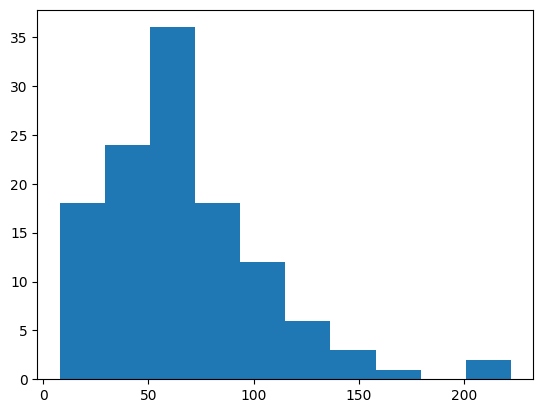

In [16]:


words = []
for i in get_files('/data/lie_detection/clips_umich/text'):
    data = read(i)
    words.append(count_words(data))

plt.hist(words)

In [8]:
# Bert. 
from transformers import BertTokenizer, BertModel
# Initialize tokenizer and model
device = torch.device('cuda:7')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
bert_model.eval()

# Move the model to GPU if available

def load_transcription_features(file_path, max_length=128):
    try:
        # Read transcription with utf-8 encoding
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
    except UnicodeDecodeError as e:
        print(f"UnicodeDecodeError: {e}")
        return np.zeros((768,))  # Return a dummy feature vector (BERT output size is 768)

    if not text:
        print(f"Error: No text found in transcription file {file_path}")
        return np.zeros((768,))  # Return a dummy feature vector

    # Tokenize text
    inputs = tokenizer(text, return_tensors='pt', max_length=max_length, truncation=True, padding='max_length').to(device)

    # Extract features using BERT
    with torch.no_grad():
        outputs = bert_model(**inputs)
    features = outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token representation

    return features.cpu().numpy().flatten()  # Move result back to CPU and convert to numpy array

# Define paths
deceptive_textfolder = os.path.join("Transcription", "Deceptive")
truthful_textfolder = os.path.join("Transcription", "Truthful")

# Initialize the feature extractor
# Function to extract features from all videos in a folder
def extract_features_from_folder(folder_path, label):
    features = []
    labels = []
    for text_name in os.listdir(folder_path):
        text_path = os.path.join(folder_path, text_name)
        if text_path.endswith(".txt"):  # Ensure it's a text file
            text_features = load_transcription_features(text_path)
            features.append(text_features)
            labels.append(label)
    return features, labels

deceptive_textfeatures, deceptive_labels = extract_features_from_folder(deceptive_textfolder, label='Deceptive')
truthful_textfeatures, truthful_labels = extract_features_from_folder(truthful_textfolder, label='Truthful')

# Combine features and labels
all_textfeatures = deceptive_textfeatures + truthful_textfeatures
all_textlabels = deceptive_labels + truthful_labels


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [50]:
save_dir = "/data/lie_detection/clips_umich/bert_cls"
mkdir(save_dir)
for file in tqdm(get_files('/data/lie_detection/clips_umich/text')):
    inputs = tokenizer(read(file), 
                    return_tensors='pt', max_length=512, truncation=True, padding='max_length').to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
        features = outputs.last_hidden_state[:, 0, :]
    
    np.save(os.path.join(save_dir, f"{get_fid(file)}.npy"), features.cpu().numpy().flatten())

100%|██████████| 120/120 [00:02<00:00, 53.74it/s]


In [51]:
import torchvision.transforms as transforms
import torchvision.models as models

In [ ]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder

class VideoFeatureExtractor:
    def __init__(self, model_name='resnet18', pretrained=True):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Load a pre-trained model
        if model_name == 'resnet18':
            self.model = models.resnet18(pretrained=pretrained)
        elif model_name == 'resnet50':
            self.model = models.resnet50(pretrained=pretrained)
        else:
            raise ValueError('Model not supported')

        # Remove the last layer
        self.model = nn.Sequential(*list(self.model.children())[:-1])
        self.model = self.model.to(self.device)
        self.model.eval()

        # Define the image transformations
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def extract_features(self, video_path, fps=4):
        # Open the video file
        cap = cv2.VideoCapture(video_path)
        frame_features = []

        # Get the original frame rate of the video
        original_fps = cap.get(cv2.CAP_PROP_FPS)
        frame_interval = int(original_fps / fps)
        
        frame_count = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            # Process every `frame_interval`-th frame
            if frame_count % frame_interval == 0:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = self.transform(frame).unsqueeze(0).to(self.device)
                
                with torch.no_grad():
                    feature = self.model(frame)
                    feature = feature.view(-1).cpu().numpy()
                    frame_features.append(feature)

            frame_count += 1
        
        cap.release()
        return np.array(frame_features)
    
# Initialize the feature extractor
extractor = VideoFeatureExtractor(model_name='resnet18', pretrained=True)

save_dir = "/data/lie_detection/clips_umich/resnet18"
mkdir(save_dir)

for file in tqdm(get_files("/data/lie_detection/clips_umich/video")):
    fid = get_fid(file)
    save_file = os.path.join(save_dir, fid + ".npy")
    features = extractor.extract_features(file)
    np.save(save_file, features)

In [ ]:
# The raw videos are stored at /data/lie_detection/clips_umich/video.
# Extract audio from the videos. 
# The audio files are stored at /data/lie_detection/clips_umich/audio.
save_dir = "/data/lie_detection/clips_umich/audio"
mkdir(save_dir)

# Use ffmpeg to extract audio from the videos.
# ffmpeg -i input.mp4 -vn -acodec pcm_s16le -ar 44100 -ac 2 output.wav
for file in tqdm(get_files("/data/lie_detection/clips_umich/video")):
    fid = get_fid(file)
    os.system(f"ffmpeg -hide_banner -loglevel error -i {file} -vn -acodec pcm_s16le -ar 44100 -ac 2 {os.path.join(save_dir, fid)}.wav")
# os.system(f"ffmpeg -i input.mp4 output.wav")

In [6]:
# Right now if you load in the audio, it's 44100 hz.
data, sr = sf.read(get_files("/data/lie_detection/clips_umich/audio")[0])
sr

16000

In [ ]:
# Now each audio has two channels. 
# Merge the two channels into one. Why? 
# Because some files appear to have single channel audio, but some have two channels.

# Also Convert all wavs into 16khz.
for file in tqdm(get_files("/data/lie_detection/clips_umich/audio")):
    data, sr = sf.read(file)
    assert data.shape[1] == 2
    data = data.mean(axis=1)
    
    data = librosa.resample(data, orig_sr = sr, target_sr = 16000)
    sf.write(file, data, 16000)

In [59]:
# Load in the audio again. Make sure that it's 16khz. 
data, sr = sf.read(get_files("/data/lie_detection/clips_umich/audio")[0])
sr

16000

In [8]:
# Now we can use WavLM to encode the audio.
# Load the model
device = torch.device('cuda:7')
model = WavLMModel.from_pretrained("microsoft/wavlm-large").to(device)
model.eval()

Some weights of the model checkpoint at microsoft/wavlm-large were not used when initializing WavLMModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing WavLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing WavLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of WavLMModel were not initialized from the model checkpoint at microsoft/wavlm-large and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and i

WavLMModel(
  (feature_extractor): WavLMFeatureEncoder(
    (conv_layers): ModuleList(
      (0): WavLMLayerNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
      (1-4): 4 x WavLMLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
      (5-6): 2 x WavLMLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): WavLMFeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=1024, bias=T

In [ ]:
# Here I'm saving the CNN output from WavLM model (i.e. outputs from layer 0)
# Your task will involve exploring other layers as well.
# We need to pre-save these features so that during training, 
# we can directly use them instead of calculating for each batch again and again. 

wav_dir = "/data/lie_detection/clips_umich/audio"
save_dir = "/data/lie_detection/clips_umich/wavlm_cnn"
mkdir(save_dir)
for file in tqdm(get_files(wav_dir)):
    fid = get_fid(file)
    data, sr = sf.read(file)
    data = torch.from_numpy(data).to(device).reshape(1, -1).float()
    with torch.no_grad():
        output = model(data, output_hidden_states=True)
    
    # TODO: Change the index here for features from different layers.
    output = output.hidden_states[0].cpu().numpy()
    np.save(os.path.join(save_dir, f"{fid}.npy"), output)

In [10]:
# Now let's process the video frames.
# We want to extract the frames from the videos.
video_dir = "/data/lie_detection/clips_umich/video"


# Let's first check fps of each video. 
all_fps = []
all_frames = []
for file in get_files(video_dir):
    cap = cv2.VideoCapture(file)
    fps = cap.get(cv2.CAP_PROP_FPS)
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # if fps < 15:
    #     print(file)
    all_fps.append(fps)
    all_frames.append(num_frames)
    cap.release()

In [11]:
min(all_fps)

10.0

In [ ]:
# As you could see, some videos have fps less than 15.
# Micro-facial expression lasts less than 0.5 sec. 
# fps of 10 means the mfe will only have 3~5 frames, where 30fps will have 15 frames.

# Also the audio feature is 50hz. 
# There're multiple ways to handle this.
# I will do linear interpolation on the vision features. 

In [ ]:
import clip
device = torch.device('cuda:7')
model, preprocess = clip.load("ViT-B/32", device=device)

In [11]:
import opensmile
save_dir = "/data/lie_detection/clips_umich/opensmile_extraction"
mkdir(save_dir)
for file in tqdm(get_files("/data/lie_detection/clips_umich/audio")):
    data, sr = sf.read(file)
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.ComParE_2016,
        feature_level=opensmile.FeatureLevel.Functionals,
    )
    fid = get_fid(file)
    y = smile.process_file(file)
    
    # Print the shape of y
    print(f"Shape of y for file {file}: {y.shape}")
    
    #y_flattened = y.values.flatten()
    
    # Print the shape of y_flattened
    #print(f"Shape of y_flattened for file {file}: {y_flattened.shape}")
    
    np.save(os.path.join(save_dir, f"{fid}.npy"), y)

    

  1%|          | 1/120 [00:00<01:43,  1.15it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_001.wav: (1, 6373)


  2%|▎         | 3/120 [00:02<01:39,  1.18it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_002.wav: (1, 6373)
Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_003.wav: (1, 6373)


  3%|▎         | 4/120 [00:03<01:12,  1.59it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_004.wav: (1, 6373)


  4%|▍         | 5/120 [00:04<01:40,  1.14it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_005.wav: (1, 6373)


  5%|▌         | 6/120 [00:04<01:25,  1.34it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_006.wav: (1, 6373)


  6%|▌         | 7/120 [00:06<01:36,  1.17it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_007.wav: (1, 6373)


  7%|▋         | 8/120 [00:06<01:12,  1.55it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_008.wav: (1, 6373)


  8%|▊         | 9/120 [00:06<01:04,  1.73it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_009.wav: (1, 6373)


  8%|▊         | 10/120 [00:07<01:05,  1.69it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_010.wav: (1, 6373)


  9%|▉         | 11/120 [00:08<01:11,  1.53it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_011.wav: (1, 6373)


 10%|█         | 12/120 [00:08<00:57,  1.88it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_012.wav: (1, 6373)


 11%|█         | 13/120 [00:08<00:53,  2.00it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_013.wav: (1, 6373)


 12%|█▏        | 14/120 [00:09<00:47,  2.24it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_014.wav: (1, 6373)


 12%|█▎        | 15/120 [00:09<00:56,  1.85it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_015.wav: (1, 6373)


 13%|█▎        | 16/120 [00:10<01:08,  1.52it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_016.wav: (1, 6373)


 14%|█▍        | 17/120 [00:11<01:18,  1.31it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_017.wav: (1, 6373)


 15%|█▌        | 18/120 [00:12<01:17,  1.31it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_018.wav: (1, 6373)


 16%|█▌        | 19/120 [00:13<01:16,  1.31it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_019.wav: (1, 6373)


 17%|█▋        | 20/120 [00:13<01:02,  1.61it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_020.wav: (1, 6373)


 18%|█▊        | 21/120 [00:13<00:54,  1.80it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_021.wav: (1, 6373)


 18%|█▊        | 22/120 [00:14<01:05,  1.49it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_022.wav: (1, 6373)


 19%|█▉        | 23/120 [00:15<01:11,  1.35it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_023.wav: (1, 6373)


 20%|██        | 24/120 [00:16<01:05,  1.46it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_024.wav: (1, 6373)


 21%|██        | 25/120 [00:17<01:07,  1.41it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_025.wav: (1, 6373)


 22%|██▏       | 26/120 [00:17<01:06,  1.41it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_026.wav: (1, 6373)


 22%|██▎       | 27/120 [00:18<01:03,  1.46it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_027.wav: (1, 6373)


 23%|██▎       | 28/120 [00:19<00:59,  1.54it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_028.wav: (1, 6373)


 24%|██▍       | 29/120 [00:19<00:53,  1.71it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_029.wav: (1, 6373)


 25%|██▌       | 30/120 [00:20<00:57,  1.57it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_030.wav: (1, 6373)


 26%|██▌       | 31/120 [00:20<00:54,  1.62it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_031.wav: (1, 6373)


 27%|██▋       | 32/120 [00:21<00:54,  1.61it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_032.wav: (1, 6373)


 28%|██▊       | 33/120 [00:22<01:00,  1.44it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_033.wav: (1, 6373)


 28%|██▊       | 34/120 [00:23<00:59,  1.44it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_034.wav: (1, 6373)


 29%|██▉       | 35/120 [00:23<01:00,  1.41it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_035.wav: (1, 6373)


 30%|███       | 36/120 [00:24<01:02,  1.34it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_036.wav: (1, 6373)


 31%|███       | 37/120 [00:25<00:58,  1.41it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_037.wav: (1, 6373)


 32%|███▏      | 38/120 [00:26<01:12,  1.13it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_038.wav: (1, 6373)


 32%|███▎      | 39/120 [00:27<01:13,  1.10it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_039.wav: (1, 6373)


 33%|███▎      | 40/120 [00:28<01:04,  1.24it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_040.wav: (1, 6373)


 34%|███▍      | 41/120 [00:28<01:04,  1.23it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_041.wav: (1, 6373)


 35%|███▌      | 42/120 [00:29<01:03,  1.22it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_042.wav: (1, 6373)


 36%|███▌      | 43/120 [00:30<00:52,  1.46it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_043.wav: (1, 6373)


 37%|███▋      | 44/120 [00:30<00:43,  1.76it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_044.wav: (1, 6373)


 38%|███▊      | 45/120 [00:30<00:40,  1.85it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_045.wav: (1, 6373)


 38%|███▊      | 46/120 [00:31<00:42,  1.75it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_046.wav: (1, 6373)


 39%|███▉      | 47/120 [00:31<00:38,  1.91it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_047.wav: (1, 6373)


 40%|████      | 48/120 [00:33<00:51,  1.40it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_048.wav: (1, 6373)


 41%|████      | 49/120 [00:33<00:47,  1.49it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_049.wav: (1, 6373)


 42%|████▏     | 50/120 [00:34<00:45,  1.53it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_050.wav: (1, 6373)


 42%|████▎     | 51/120 [00:34<00:36,  1.91it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_051.wav: (1, 6373)


 43%|████▎     | 52/120 [00:35<00:45,  1.49it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_052.wav: (1, 6373)


 44%|████▍     | 53/120 [00:36<00:45,  1.48it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_053.wav: (1, 6373)


 45%|████▌     | 54/120 [00:36<00:39,  1.67it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_054.wav: (1, 6373)


 46%|████▌     | 55/120 [00:37<00:42,  1.54it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_055.wav: (1, 6373)


 47%|████▋     | 56/120 [00:37<00:41,  1.54it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_056.wav: (1, 6373)


 48%|████▊     | 57/120 [00:38<00:37,  1.67it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_057.wav: (1, 6373)


 48%|████▊     | 58/120 [00:39<00:36,  1.71it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_058.wav: (1, 6373)


 49%|████▉     | 59/120 [00:40<00:44,  1.38it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_059.wav: (1, 6373)


 50%|█████     | 60/120 [00:40<00:41,  1.45it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_lie_060.wav: (1, 6373)


 51%|█████     | 61/120 [00:41<00:35,  1.68it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_001.wav: (1, 6373)


 52%|█████▏    | 62/120 [00:41<00:32,  1.77it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_002.wav: (1, 6373)


 52%|█████▎    | 63/120 [00:41<00:27,  2.06it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_003.wav: (1, 6373)


 53%|█████▎    | 64/120 [00:43<00:44,  1.27it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_004.wav: (1, 6373)


 54%|█████▍    | 65/120 [00:44<00:41,  1.32it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_005.wav: (1, 6373)


 55%|█████▌    | 66/120 [00:44<00:38,  1.39it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_006.wav: (1, 6373)


 56%|█████▌    | 67/120 [00:46<00:48,  1.08it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_007.wav: (1, 6373)


 57%|█████▋    | 68/120 [00:47<00:50,  1.03it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_008.wav: (1, 6373)


 57%|█████▊    | 69/120 [00:47<00:43,  1.17it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_009.wav: (1, 6373)


 58%|█████▊    | 70/120 [00:49<00:52,  1.06s/it]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_010.wav: (1, 6373)


 59%|█████▉    | 71/120 [00:50<00:48,  1.02it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_011.wav: (1, 6373)


 60%|██████    | 72/120 [00:50<00:42,  1.12it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_012.wav: (1, 6373)


 61%|██████    | 73/120 [00:51<00:38,  1.22it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_013.wav: (1, 6373)


 62%|██████▏   | 74/120 [00:51<00:30,  1.49it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_014.wav: (1, 6373)


 62%|██████▎   | 75/120 [00:53<00:47,  1.06s/it]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_015.wav: (1, 6373)


 63%|██████▎   | 76/120 [00:54<00:39,  1.10it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_016.wav: (1, 6373)


 64%|██████▍   | 77/120 [00:54<00:32,  1.32it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_017.wav: (1, 6373)


 65%|██████▌   | 78/120 [00:55<00:28,  1.46it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_018.wav: (1, 6373)


 67%|██████▋   | 80/120 [00:55<00:18,  2.21it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_019.wav: (1, 6373)
Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_020.wav: (1, 6373)


 68%|██████▊   | 81/120 [00:55<00:15,  2.51it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_021.wav: (1, 6373)


 68%|██████▊   | 82/120 [00:56<00:18,  2.07it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_022.wav: (1, 6373)


 69%|██████▉   | 83/120 [00:57<00:18,  1.99it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_023.wav: (1, 6373)


 70%|███████   | 84/120 [00:57<00:18,  1.94it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_024.wav: (1, 6373)


 71%|███████   | 85/120 [00:58<00:23,  1.47it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_025.wav: (1, 6373)


 72%|███████▏  | 86/120 [01:00<00:30,  1.13it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_026.wav: (1, 6373)


 72%|███████▎  | 87/120 [01:01<00:38,  1.17s/it]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_027.wav: (1, 6373)


 73%|███████▎  | 88/120 [01:03<00:39,  1.23s/it]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_028.wav: (1, 6373)


 74%|███████▍  | 89/120 [01:04<00:34,  1.11s/it]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_029.wav: (1, 6373)


 75%|███████▌  | 90/120 [01:05<00:33,  1.11s/it]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_030.wav: (1, 6373)


 76%|███████▌  | 91/120 [01:05<00:26,  1.09it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_031.wav: (1, 6373)


 77%|███████▋  | 92/120 [01:06<00:25,  1.10it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_032.wav: (1, 6373)


 78%|███████▊  | 93/120 [01:07<00:21,  1.28it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_033.wav: (1, 6373)


 78%|███████▊  | 94/120 [01:07<00:20,  1.26it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_034.wav: (1, 6373)


 79%|███████▉  | 95/120 [01:08<00:19,  1.25it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_035.wav: (1, 6373)


 80%|████████  | 96/120 [01:09<00:20,  1.16it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_036.wav: (1, 6373)


 81%|████████  | 97/120 [01:10<00:17,  1.29it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_037.wav: (1, 6373)


 82%|████████▏ | 98/120 [01:10<00:15,  1.42it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_038.wav: (1, 6373)


 82%|████████▎ | 99/120 [01:11<00:15,  1.38it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_039.wav: (1, 6373)


 83%|████████▎ | 100/120 [01:12<00:14,  1.39it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_040.wav: (1, 6373)


 84%|████████▍ | 101/120 [01:13<00:14,  1.32it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_041.wav: (1, 6373)


 85%|████████▌ | 102/120 [01:13<00:13,  1.34it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_042.wav: (1, 6373)


 86%|████████▌ | 103/120 [01:14<00:11,  1.45it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_043.wav: (1, 6373)


 87%|████████▋ | 104/120 [01:14<00:10,  1.56it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_044.wav: (1, 6373)


 88%|████████▊ | 105/120 [01:15<00:10,  1.48it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_045.wav: (1, 6373)


 88%|████████▊ | 106/120 [01:16<00:10,  1.39it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_046.wav: (1, 6373)


 89%|████████▉ | 107/120 [01:17<00:09,  1.40it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_047.wav: (1, 6373)


 90%|█████████ | 108/120 [01:17<00:08,  1.42it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_048.wav: (1, 6373)


 91%|█████████ | 109/120 [01:18<00:08,  1.37it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_049.wav: (1, 6373)


 92%|█████████▏| 110/120 [01:19<00:07,  1.37it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_050.wav: (1, 6373)


 92%|█████████▎| 111/120 [01:20<00:06,  1.31it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_051.wav: (1, 6373)


 93%|█████████▎| 112/120 [01:21<00:06,  1.30it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_052.wav: (1, 6373)


 94%|█████████▍| 113/120 [01:22<00:05,  1.22it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_053.wav: (1, 6373)


 95%|█████████▌| 114/120 [01:22<00:04,  1.31it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_054.wav: (1, 6373)


 96%|█████████▌| 115/120 [01:23<00:03,  1.44it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_055.wav: (1, 6373)


 97%|█████████▋| 116/120 [01:23<00:02,  1.45it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_056.wav: (1, 6373)


 98%|█████████▊| 117/120 [01:24<00:02,  1.36it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_057.wav: (1, 6373)


 98%|█████████▊| 118/120 [01:25<00:01,  1.47it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_058.wav: (1, 6373)


 99%|█████████▉| 119/120 [01:26<00:00,  1.44it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_059.wav: (1, 6373)


100%|██████████| 120/120 [01:26<00:00,  1.39it/s]

Shape of y for file /data/lie_detection/clips_umich/audio/trial_truth_060.wav: (1, 6373)


In [19]:
# Run ViT.py. 
save_dir = "/data/lie_detection/clips_umich/viT"
mkdir(save_dir)

# Save images.
temp_dir = "/data/lie_detection/clips_umich/temp"
mkdir(temp_dir)

for file in get_files("/data/lie_detection/clips_umich/video"):
    save_path = os.path.join(save_dir, f"{fid}.npy")
    if os.path.exists(save_path):
        continue
    
    fid = get_fid(file)
    cap = cv2.VideoCapture(file)
    frames = []
    count = 0
    progress_bar = tqdm(total=int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        cv2.imwrite(os.path.join(temp_dir, f"{count}.png"), frame)     # save frame as PnG file
        count += 1
        progress_bar.update(1)
    cap.release()
    
    images = [Image.open(i).convert('RGB') for i in get_files(temp_dir)]
    frames = torch.stack([preprocess(i).to(device) for i in images])
    with torch.no_grad():
        output = model.encode_image(frames)
    
    np.save(save_path, output.cpu().numpy())
    
    # Clean up
    for i in get_files(temp_dir):
        os.remove(i)
    assert len(get_files(temp_dir)) == 0

# Data Split

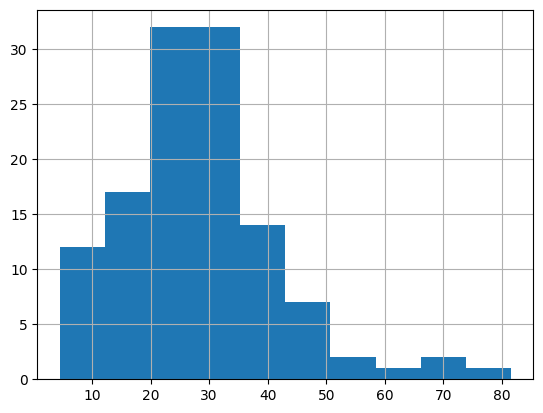

In [20]:
# TODO: Please check the following pipeline for creating the dataset. 
# To properly create the split, we first check the length of each data. 
duration = []
for file in get_files("/data/lie_detection/clips_umich/video"):
    # Open a file reader
    cap = cv2.VideoCapture(file)
    
    # Get fps.
    fps = cap.get(cv2.CAP_PROP_FPS)
    # Get total number of frames in the video.
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # Calculate duration. 
    duration.append(num_frames/fps)
    # Close the file reader. 
    cap.release()
plt.hist(duration)
plt.grid()
plt.show()

In [71]:
# Although the duration distribution is a little bit skewed, (not toooo far away from normal distribution)
# we can still use random sampling (i.e. uniform distribution) to split the data.
# This way we can ensure that the distribution of duration is similar in both train and test sets.

In [43]:
# Let's follow a 80, 10, 10 split for now. 

import numpy as np
from sklearn.model_selection import KFold

fids = [get_fid(i) for i in get_files("/data/lie_detection/clips_umich/video")]

# Some lucky number. 
np.random.seed(888)

# Shuffle the fids.
random.shuffle(fids)

# Split the fids.
#train_fids = fids[:int(len(fids)*0.8)]
#val_fids = fids[int(len(fids)*0.8):int(len(fids)*0.9)]
#test_fids = fids[int(len(fids)*0.9):]
n_total = len(fids)
n_train = int(n_total * 0.7)
n_val = int(n_total * 0.1)

train_fids = fids[:n_train]
val_fids = fids[n_train:n_train + n_val]
test_fids = fids[n_train + n_val:]


# Save the splits.
write("/data/lie_detection/clips_umich/train.txt", "\n".join(train_fids))
write("/data/lie_detection/clips_umich/val.txt", "\n".join(val_fids))
write("/data/lie_detection/clips_umich/test.txt", "\n".join(test_fids))    

print(f"Number of training samples: {len(train_fids)}")
print(f"Number of validation samples: {len(val_fids)}")
print(f"Number of test samples: {len(test_fids)}")


Number of training samples: 84
Number of validation samples: 12
Number of test samples: 24


In [4]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class MultiModalDataset(Dataset):
    def __init__(self, audio_dir, visual_dir, split_file):
        # Split file only gives us file IDs. We still need data directories.
        self.audio_dir = audio_dir
        self.visual_dir = visual_dir
        with open(split_file, 'r') as f:
            fids = f.read().splitlines()
        
        # Get all files. This also ensures that 
        # getting index i from audio_files and visual_files will give us the file pointing to the same sample.
        self.audio_files = [os.path.join(audio_dir, f"{i}.npy") for i in fids]
        self.visual_files = [os.path.join(visual_dir, f"{i}.npy") for i in fids]

        # Extract labels from file IDs
        self.labels = [1 if 'lie' in fid.lower() else 0 for fid in fids]

        # Ensure that these files exist. 
        for i in self.audio_files:
            assert os.path.exists(i), f"File not found: {i}"
        for i in self.visual_files:
            assert os.path.exists(i), f"File not found: {i}"
    
    def __getitem__(self, idx):
        # We first read in the audio and visual features.
        # (1, T, C). We squeeze the first dimension. => (T, C)
        audio_features = np.load(self.audio_files[idx])
        #audio_features = audio_features[0]
        
        # (T, C)
        visual_features = np.load(self.visual_files[idx])
        

        
        # Sometimes the features may be a few frames off, but no more than 5 frames.
        # Take the minimum of the two lengths. (i.e., chunk the longer one to the length of the shorter one)
        #assert abs(audio_features.shape[0] - visual_features.shape[0]) < 5, "Audio and visual features should have frame difference less than 5."
        
        min_length = min(audio_features.shape[0], visual_features.shape[0])
        audio_features = audio_features[:min_length]
        visual_features = visual_features[:min_length]
        
        # Concatenate them on the last channel dimension. 
        concat_data = np.concatenate((audio_features, visual_features), axis=-1)
        
        # Convert the numpy array to a PyTorch tensor.
        concat_data = torch.from_numpy(concat_data).float()
        
        # Get the label for this sample
        label = self.labels[idx]
        label = torch.tensor(label, dtype=torch.long)

        return concat_data, label
    
    def __len__(self):
        return len(self.audio_files)

def collate_fn(batch):
    # Separate the data and labels
    data, labels = zip(*batch)
    
    # We will pad the sequence with 0s to the maximum length in the batch.
    max_len = max([i.shape[0] for i in data])
    padded_batch = []
    for i in data:
        pad_len = max_len - i.shape[0]
        padded_batch.append(torch.nn.functional.pad(i, (0, 0, 0, pad_len)))
    
    # Now all samples have the same length. 
    # We can stack them into a tensor.
    # Shape: (batch_size, T, C)
    data = torch.stack(padded_batch)
    
    # Stack labels into a tensor
    labels = torch.tensor(labels)
    
    return data, labels

# Now let's test the dataset.
audio_dir = "/data/lie_detection/clips_umich/opensmile_extraction"
visual_dir = "/data/lie_detection/clips_umich/viT_50hz"
split_file = "/data/lie_detection/clips_umich/train.txt"

dataset = MultiModalDataset(audio_dir, visual_dir, split_file)
print(f"dataset sample shape: {dataset[0][0].shape}, label: {dataset[0][1]}")

# We don't need further processing. Can just use the default dataloader.
# Always set shuffle to True for training. False for validation and testing.
# Adjust batch_size and num_workers based on your GPU memory and CPU count. 

######### IMPORTANT #########
# Don't set num_workers above 8. There're only 64 threads in total on the server.
# num_workers of 2 or 4 should be good enough for most cases.
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2, collate_fn=collate_fn)

# Now let's test the dataloader.
# iter function will return an iterator.
# next function will return the next batch.

# Batch will have a shape of (batch_size, T, C). 
# C = 1024 + 512 = 1536
# T is the maximum length in the batch.
batch = next(iter(dataloader))
print(batch[0].shape, batch[1].shape)

dataset sample shape: torch.Size([1, 6885]), label: 1


torch.Size([8, 1, 6885]) torch.Size([8])


# only audio loader

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class VisualDataset(Dataset):
    def __init__(self, visual_dir, split_file):
        # Split file only gives us file IDs. We still need data directories.
        self.visual = visual_dir
        with open(split_file, 'r') as f:
            fids = f.read().splitlines()
        self.visual_files = [os.path.join(visual_dir, f"{i}.npy") for i in fids]
        self.labels = [1 if 'lie' in fid.lower() else 0 for fid in fids]

        for i in self.visual_files:
            assert os.path.exists(i), f"File not found: {i}"
    
    def __getitem__(self, idx):
        # We first read in the audio and visual features.
        # (1, T, C). We squeeze the first dimension. => (T, C)
        visual_features = np.load(self.visual_files[idx])
        #audio_features = audio_features[0]
        
        # Sometimes the features may be a few frames off, but no more than 5 frames.
        # Take the minimum of the two lengths. (i.e., chunk the longer one to the length of the shorter one)
        #assert abs(audio_features.shape[0] - visual_features.shape[0]) < 5, "Audio and visual features should have frame difference less than 5."
        # Concatenate them on the last channel dimension. 
        #concat_data = np.concatenate((audio_features, visual_features), axis=-1)
        dataset = visual_features
        # Convert the numpy array to a PyTorch tensor.
        dataset = torch.from_numpy(dataset).float()
        # Get the label for this sample
        label = self.labels[idx]
        label = torch.tensor(label, dtype=torch.long)

        return dataset, label
    
    def __len__(self):
        return len(self.visual_files)

def collate_fn(batch):
    # Separate the data and labels
    data, labels = zip(*batch)
    # We will pad the sequence with 0s to the maximum length in the batch.
    max_len = max([i.shape[0] for i in data])
    padded_batch = []
    for i in data:
        pad_len = max_len - i.shape[0]
        padded_batch.append(torch.nn.functional.pad(i, (0, 0, 0, pad_len)))
    
    # Now all samples have the same length. 
    # We can stack them into a tensor.
    # Shape: (batch_size, T, C)
    data = torch.stack(padded_batch)
    
    # Stack labels into a tensor
    labels = torch.tensor(labels)
    
    return data, labels

# Now let's test the dataset.
visual_dir = "/data/lie_detection/clips_umich/viT_50hz"
split_file = "/data/lie_detection/clips_umich/train.txt"

dataset = VisualDataset(audio_dir, split_file)
print(f"dataset sample shape: {dataset[0][0].shape}, label: {dataset[0][1]}")

# We don't need further processing. Can just use the default dataloader.
# Always set shuffle to True for training. False for validation and testing.
# Adjust batch_size and num_workers based on your GPU memory and CPU count. 

######### IMPORTANT #########
# Don't set num_workers above 8. There're only 64 threads in total on the server.
# num_workers of 2 or 4 should be good enough for most cases.
visual_dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2, collate_fn=collate_fn)

# Now let's test the dataloader.
# iter function will return an iterator.
# next function will return the next batch.

# Batch will have a shape of (batch_size, T, C). 
# C = 1024 + 512 = 1536
# T is the maximum length in the batch.
batch = next(iter(visual_dataloader))
print(batch[0].shape, batch[1].shape)

In [19]:

# Here's quick example of how padding works.
# Let's say the current data has shape (T, C)
# We want to pad the T to 5. 
data = torch.rand((2, 8))
result = torch.nn.functional.pad(data, (0, 0, 0, 3))

result, result.shape

(tensor([[0.1349, 0.7725, 0.3627, 0.4999, 0.9895, 0.0144, 0.8421, 0.8704],
         [0.4715, 0.5765, 0.5355, 0.4579, 0.1864, 0.7845, 0.2348, 0.8641],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]),
 torch.Size([5, 8]))

In [56]:
#TODO 
    #save as truth  

# Be sure to convert the model & data to the correct device.
# Evaluate the model on the validation set.
# Save the model with the best validation performance.
# Test the model with the best validation performance on the test set.

# Visual feature interpolation

In [ ]:
import cv2
############### 1. Load the video fps ###############
video_dir = "/data/lie_detection/clips_umich/video"


# Let's first check fps of each video. 
all_fps = {}
all_frames = []
for file in get_files(video_dir):
    cap = cv2.VideoCapture(file)
    fps = cap.get(cv2.CAP_PROP_FPS)
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # if fps < 15:
    #     print(file)
    all_fps[get_fid(file)] = fps
    all_frames.append(num_frames)
    cap.release()
    
############### 2. Interpolate visual features ###############
device = torch.device('cuda:7')

# We will save the interpolated features in this folder.
save_dir = "/data/lie_detection/clips_umich/viT_50hz"
mkdir(save_dir)

# To get all files in a folder in a sorted order, just use 'get_files(folder)'
# tqdm simply adds a progress bar. 
for file in tqdm(get_files('/data/lie_detection/clips_umich/viT')):
    # Get the file id. We want to save the file with the same id.
    fid = get_fid(file)
    fps = all_fps[fid]
    
    # Interpolate the frames to 50hz. 
    # (T, C)
    # Want (B, C, T) as input shape. to the interpolate. 
    # Use GPU so that it's faster.
    data = np.load(file)
    data = torch.from_numpy(data).to(device).float()
    
    # Convert input shape from (T, C) => (1, T, C) => (1, C, T)
    data = data.unsqueeze(0).transpose(1, 2)
    target_len = int(data.shape[2] * 50 / fps)
    data = torch.nn.functional.interpolate(data, size=target_len, mode='linear', align_corners=False)
    data = data.squeeze(0).transpose(0, 1)
    
    # Save data.
    # Before save, move data back to cpu else it will error.
    np.save(os.path.join(save_dir, f"{fid}.npy"), data.cpu().numpy())

In [ ]:
# Sanity check. 
#data = np.load("/data/lie_detection/clips_umich/viT_50hz/trial_lie_001.npy")
#previous_data = np.load("/data/lie_detection/clips_umich/viT/trial_lie_001.npy")

print(f"After Interpolation data shape: {data.shape}")
print(f"Before interpolation data shape: {previous_data.shape}")

print(f"Previous video fps: {all_fps['trial_lie_001']}")

# You can see that the length indeed match 50hz. 
510 / 29.97 * 50

# FiLM Architecture


In [5]:
def conv1d(ic, oc, k, s, p):
    return nn.Sequential(
        nn.Conv1d(ic, oc, k, s, p),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(oc),
    )

class FeatureExtractor(nn.Module):
    def __init__(self, in_channels):
        super(FeatureExtractor, self).__init__()
        
        self.model = nn.Sequential(
            conv1d(in_channels, 128, 5, 2, 2),
            conv1d(128, 128, 3, 2, 1),
            conv1d(128, 128, 3, 2, 1),
            conv1d(128, 128, 3, 1, 1),
            conv1d(128, 128, 3, 1, 1),
        )
        
    def forward(self, x):
        return self.model(x)

class FiLMBlock(nn.Module):
    def __init__(self):
        super(FiLMBlock, self).__init__()
        
    def forward(self, x, gamma, beta):
        beta = beta.view(x.size(0), x.size(1), 1)
        gamma = gamma.view(x.size(0), x.size(1), 1)
        
        x = gamma * x + beta
        
        return x

class ResBlock(nn.Module):
    def __init__(self, in_place, out_place):
        super(ResBlock, self).__init__()
        
        self.conv1 = nn.Conv1d(in_place, out_place, 1, 1, 0)
        self.relu1 = nn.ReLU(inplace=True)
        self.norm1 = nn.BatchNorm1d(out_place)
        self.conv2 = nn.Conv1d(out_place, out_place, 3, 1, 1)
        self.norm2 = nn.BatchNorm1d(out_place)
        self.film = FiLMBlock()
        self.relu2 = nn.ReLU(inplace=True)
        
    def forward(self, x, beta, gamma):
        x = self.conv1(x)
        x = self.relu1(x)
        identity = x
        x = self.norm1(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.film(x, gamma, beta)
        x = self.relu2(x)
        
        x = x + identity
        
        return x

class Classifier(nn.Module):
    def __init__(self, prev_channels, n_classes):
        super(Classifier, self).__init__()
        
        self.conv = nn.Conv1d(prev_channels, 512, 1, 1, 0)
        self.relu = nn.ReLU(inplace=True)
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)
        self.model = nn.Sequential(nn.Linear(512, 1024),
                                   nn.ReLU(inplace=True),
                                   nn.Linear(1024, 1024),
                                   nn.ReLU(inplace=True),
                                   nn.Linear(1024, n_classes))
        
    def forward(self, x):
        x = self.conv(x)
        x = self.global_max_pool(x)
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = self.model(x)
        
        return x

class FiLM(nn.Module):
    def __init__(self, n_res_blocks, n_classes, n_channels, in_channels):
        super(FiLM, self).__init__()
        dim_question = 11
        self.film_generator = nn.Linear(dim_question, 2 * n_res_blocks * n_channels)
        self.feature_extractor = FeatureExtractor(in_channels)
        self.res_blocks = nn.ModuleList()
        
        for _ in range(n_res_blocks):
            self.res_blocks.append(ResBlock(n_channels + 2, n_channels))
            
        self.dropout = nn.Dropout(p=0.5)  # Add dropout layer
        self.classifier = Classifier(n_channels, n_classes)
    
        self.n_res_blocks = n_res_blocks
        self.n_channels = n_channels
        
    def forward(self, x, question):
        batch_size = x.size(0)
        if x.dim() == 5:
            # Remove extra dimensions
            x = x.squeeze(-1).squeeze(-1)
        x = self.feature_extractor(x)
        film_vector = self.film_generator(question).view(
            batch_size, self.n_res_blocks, 2, self.n_channels)
        
        d = x.size(2)
        coordinate = torch.linspace(-1, 1, d).to(x.device)
        coordinate_x = coordinate.view(1, 1, d).expand(batch_size, 1, d)
        coordinate_y = coordinate.view(1, 1, d).expand(batch_size, 1, d)
        
        for i, res_block in enumerate(self.res_blocks):
            beta = film_vector[:, i, 0, :].unsqueeze(2)
            gamma = film_vector[:, i, 1, :].unsqueeze(2)
            
            x = torch.cat([x, coordinate_x, coordinate_y], 1)
            x = res_block(x, beta, gamma)
        
        x = self.dropout(x)  # Apply dropout
        x = self.classifier(x)
        
        return x
def make_model(model_params):
    return FiLM(**model_params)